# Encoding with LeNet5

In [1]:
import torch
import torchvision
import numpy as np

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

## Loading the classifier and selecting layers

In [3]:
classifier = torch.load(".checkpoint/model_checkpoint.pt",weights_only=False)
print(classifier)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
encoder = nn.Sequential(*list(classifier.children())[:11])

# Congela i parametri
for param in encoder.parameters():
    param.requires_grad = False

print(encoder)


Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
)


In [5]:
decoder = nn.Sequential(
    nn.Linear(84, 120),
    nn.ReLU(),
    nn.Linear(120,400),
    nn.ReLU(),
    nn.Unflatten(1, (16, 5, 5)),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(16, 6, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=0),
    nn.Sigmoid()
)

In [6]:
autoencoder = nn.Sequential(
    encoder,
    decoder
)

autoencoder = autoencoder.to(device, non_blocking=True)

## Loading images

In [7]:
# transform = transforms.Normalize((0.14,), (0.25,))      # Set mean to 0 and  var to 1

images, labels = torch.load('./.data/MNIST32_train.pkl')
# images = transform(images) 

all_train = torch.utils.data.TensorDataset(images, labels) 
train_size = int(0.9 * len(all_train))
val_size = len(all_train) - train_size

train_set, val_set = torch.utils.data.random_split(all_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

images, labels = torch.load('./.data/MNIST32_val.pkl')
# images = transform(images) 

test_data = torch.utils.data.TensorDataset(images, labels)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

## Noise adding function

In [8]:
import torchvision.transforms.v2


def add_noise(images, mean = 0, std=0.1):
    noise_transform = torchvision.transforms.v2.GaussianNoise(mean,std)
    return noise_transform(images).clamp(0,1)

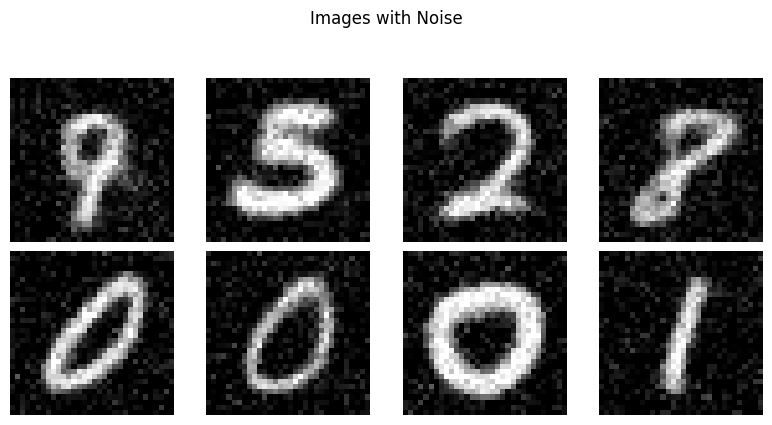

In [9]:
import matplotlib.pyplot as plt

def plot_images(images, title):
    plt.figure(figsize=(8, 4))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()

noisy_images = [img.cpu() for img in add_noise(images.to(device))]

plot_images(noisy_images, title="Images with Noise")

## Training

In [11]:
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # [0,1] immagini
mse = nn.functional.binary_cross_entropy


optimizer = optim.Adam(autoencoder.parameters(),
                       lr=1e-3,
                       weight_decay=1e-6)

In [12]:
def pixel_accuracy(reconstructed, target, threshold=0.05):
    correct = torch.abs(reconstructed - target) < threshold
    return correct.float().mean().item()

In [13]:
# this code is taken from https://github.com/Bjarten/early-stopping-pytorch
# Copyright (c) 2018 Bjarte Mehus Sunde under MIT License
# to see full license consult the NOTICE.txt file on the Github repository from which this notebook is taken from

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0


  def save_checkpoint(self, model):
    torch.save(model, self.path)

In [14]:
EPOCHS = 50
train_loss = []
val_loss = []
train_acc = []
val_acc = []



early_stopper = EarlyStopping(patience = 5, path=".checkpoint/autoencoder_checkpoint.pt")

for epoch in range(EPOCHS):
    autoencoder.train()
    tloss = 0
    tacc = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device, non_blocking = True)

        pred = autoencoder(x)

        mse_value = mse(pred, x)
        loss = mse_value

        for param in autoencoder.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()

        tloss += loss.detach()
        tacc += pixel_accuracy(pred, x)

    train_loss.append(tloss/len(train_loader))
    train_acc.append(tacc/len(train_loader))

    autoencoder.eval()
    tloss = 0
    tacc = 0
    for batch_idx, (x, _) in enumerate(val_loader):
        x = x.to(device, non_blocking = True)

        pred = autoencoder(x)

        mse_value = mse(pred, x)
        loss = mse_value
        tloss += loss.detach()
        tacc += pixel_accuracy(pred, x)
    
    val_loss.append(tloss/len(val_loader))
    val_acc.append(tacc/len(val_loader))

    early_stopper(val_loss[-1], autoencoder)
    print(f"Epoch {epoch + 1}: \nTrain Loss = {train_loss[-1]:.5f}, Validation Loss = {val_loss[-1]:.5f}")
    print(f"Train Acc = {train_acc[-1]:-5f}, Validation Acc = {val_acc[-1]:-5f}")
    if early_stopper.early_stop:
      print("Early stopping triggered.")
      break


Epoch 1: 
Train Loss = 0.22727, Validation Loss = 0.18647
Train Acc = 0.647074, Validation Acc = 0.729815
Epoch 2: 
Train Loss = 0.18034, Validation Loss = 0.17630
Train Acc = 0.745507, Validation Acc = 0.751744
Epoch 3: 
Train Loss = 0.17301, Validation Loss = 0.17120
Train Acc = 0.765234, Validation Acc = 0.774676
Epoch 4: 
Train Loss = 0.16959, Validation Loss = 0.16815
Train Acc = 0.775813, Validation Acc = 0.776059
Epoch 5: 
Train Loss = 0.16725, Validation Loss = 0.16683
Train Acc = 0.783374, Validation Acc = 0.790050
Epoch 6: 
Train Loss = 0.16570, Validation Loss = 0.16531
Train Acc = 0.788899, Validation Acc = 0.794891
Epoch 7: 
Train Loss = 0.16456, Validation Loss = 0.16417
Train Acc = 0.792956, Validation Acc = 0.797365
Epoch 8: 
Train Loss = 0.16359, Validation Loss = 0.16315
Train Acc = 0.796758, Validation Acc = 0.799580
Epoch 9: 
Train Loss = 0.16283, Validation Loss = 0.16265
Train Acc = 0.799692, Validation Acc = 0.802620
Epoch 10: 
Train Loss = 0.16222, Validation Lo

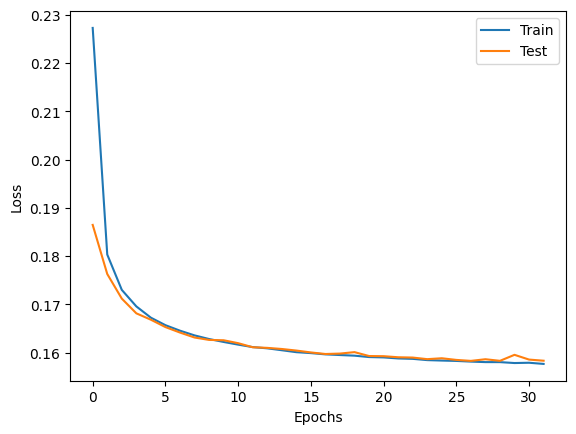

In [15]:
import matplotlib.pyplot as plt
train_loss = [it.cpu() for it in train_loss]
tloss = [it.cpu() for it in val_loss]
plt.plot(train_loss, label = "Train")
plt.plot(tloss, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

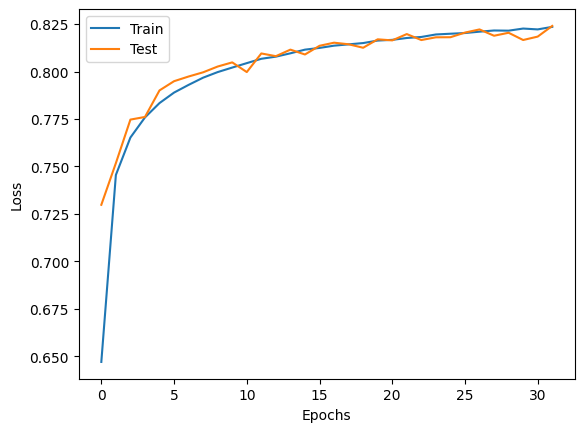

In [16]:
train_acc = [it for it in train_acc]
tacc= [it for it in val_acc]
plt.plot(train_acc, label = "Train")
plt.plot(tacc, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

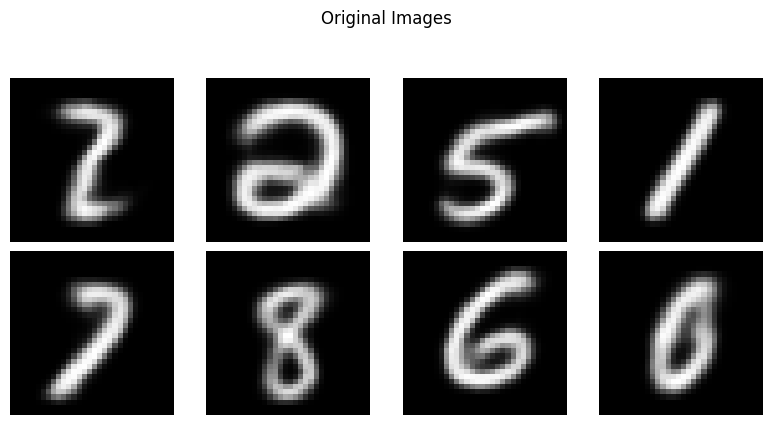

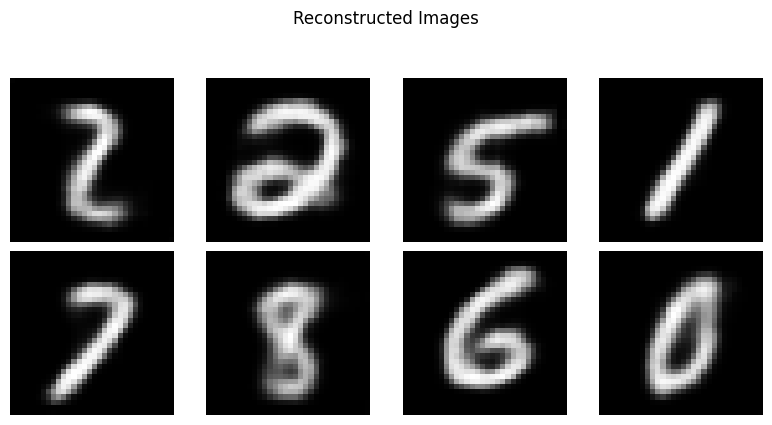

In [17]:
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        reconstructed_images = autoencoder(images)
        break

def plot_images(images, title):
    plt.figure(figsize=(8, 4))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i+16].squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()

# plot original and reconstructed images
images = [img.cpu() for img in images]
reconstructed_images = [img.cpu() for img in reconstructed_images]
plot_images(images, title="Original Images")
plot_images(reconstructed_images, title="Reconstructed Images")


In [18]:
autoencoder.eval()
tloss = 0
tacc = 0
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(device, non_blocking = True)
    pred = autoencoder(x)

    mse_value = mse(pred, x)
    loss = mse_value

    tloss += loss.detach()
    tacc += pixel_accuracy(pred, x)

tloss = (tloss/len(test_loader))
tacc = (tacc/len(test_loader))
print(f"Test Loss = {tloss:-5f}, Test Acc = {tacc:-5f}")

Test Loss = 0.158296, Test Acc = 0.824443
